### Andrew Taylor
### atayl136

# Assignment 10

1. [10 pts] Look around the Torch Geometric datasets page, torch_geometric.datasets, and
note the number of nodes, edges, features, and classes for a few datasets. Submit this list
as your answer.

_For this question I chose to load and detail the first graph in each dataset because the datasets are so huge._

This question was so hard,  so many datasets have moved or have classes with idiosyncratic arguments. I finally got a hold of these three.

In [21]:
import torch
from torch_geometric.datasets import KarateClub, Planetoid
from torch_geometric.data import Data
from tabulate import tabulate
import os

# Root directory for storing datasets
root_dir = os.path.join(os.getcwd(), 'data')

def get_graph_info(name: str, data: Data, num_classes: int = None):
    return {
        "Dataset": name,
        "Nodes": data.num_nodes,
        "Edges": data.num_edges,
        "Features": data.num_features,
        "Classes": num_classes if num_classes is not None else "N/A"
    }

def load_first_graph(dataset_class, dataset_id, root='data', **kwargs):
    processed_path = os.path.join(root, dataset_id, 'processed', 'first_graph.pt')

    if os.path.exists(processed_path):
        print(f"Loading cached {dataset_id} graph from: {processed_path}")
        data = torch.load(processed_path)
    else:
        print(f"Loading and processing {dataset_id} (only first graph)...")
        dataset = dataset_class(root=os.path.join(root, dataset_id), **kwargs)
        data = dataset[0]
        os.makedirs(os.path.dirname(processed_path), exist_ok=True)
        torch.save(data, processed_path)
        print(f"Saved first graph to: {processed_path}")

    return data

# Collect all dataset stats
results = []

# KarateClub
karate = load_first_graph(KarateClub, 'KarateClub')
results.append(get_graph_info("KarateClub", karate, num_classes=4))

# CiteSeer (as GitHub replacement)
citeseer = load_first_graph(Planetoid, 'CiteSeer', name='CiteSeer')
results.append(get_graph_info("CiteSeer", citeseer, num_classes=6))

# Cora
cora = load_first_graph(Planetoid, 'Cora', name='Cora')
results.append(get_graph_info("Cora", cora, num_classes=7))

# Display summary
print(tabulate(results, headers="keys", tablefmt="fancy_grid"))


Loading cached KarateClub graph from: data\KarateClub\processed\first_graph.pt
Loading and processing CiteSeer (only first graph)...


C:\Users\Putna\AppData\Local\Temp\ipykernel_31032\1223534574.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(processed_path)


Saved first graph to: data\CiteSeer\processed\first_graph.pt
Loading and processing Cora (only first graph)...
Saved first graph to: data\Cora\processed\first_graph.pt
╒════════════╤═════════╤═════════╤════════════╤═══════════╕
│ Dataset    │   Nodes │   Edges │   Features │   Classes │
╞════════════╪═════════╪═════════╪════════════╪═══════════╡
│ KarateClub │      34 │     156 │         34 │         4 │
├────────────┼─────────┼─────────┼────────────┼───────────┤
│ CiteSeer   │    3327 │    9104 │       3703 │         6 │
├────────────┼─────────┼─────────┼────────────┼───────────┤
│ Cora       │    2708 │   10556 │       1433 │         7 │
╘════════════╧═════════╧═════════╧════════════╧═══════════╛


Processing...
Done!


2. [10 pts] Load the Actor dataset and demonstrate a regular NN and a GNN on this dataset
using a train-test split evaluation.

[Epoch 50] NN Loss: 0.9826, GCN Loss: 1.2402
[Epoch 100] NN Loss: 0.7440, GCN Loss: 1.0874
[Epoch 150] NN Loss: 0.6655, GCN Loss: 1.0253
[Epoch 200] NN Loss: 0.6285, GCN Loss: 0.9930
NN Classification Report


Loading ITables v2.4.4 from the internet... (need help?)


GCN Classification Report


Loading ITables v2.4.4 from the internet... (need help?)


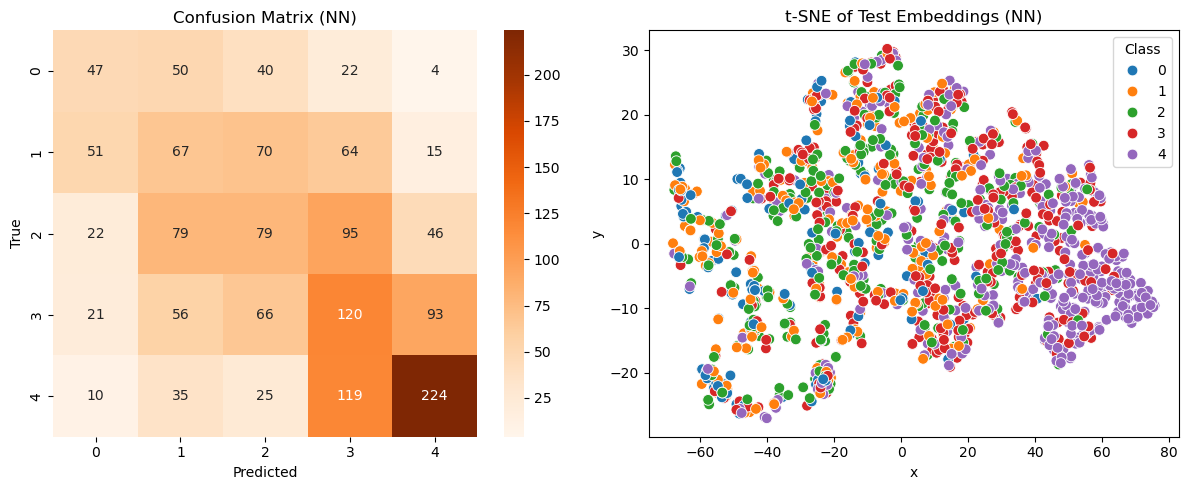

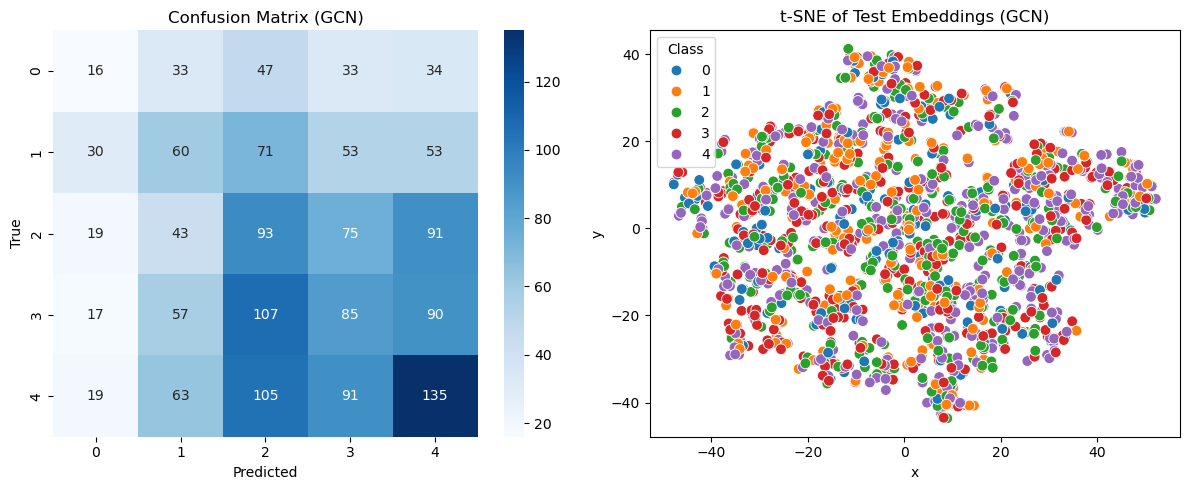

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Actor
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ace_tools_open as tools


# Load Actor dataset
dataset = Actor(root='data/Actor')
data = dataset[0]

# Manual train/test split
torch.manual_seed(42)
perm = torch.randperm(data.num_nodes)
train_idx = perm[:int(0.8 * data.num_nodes)]
test_idx = perm[int(0.8 * data.num_nodes):]

# 3-layer MLP model
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin3(x)

# 3-layer GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

# Initialize models
nn_model = MLP(data.num_features, 64, dataset.num_classes)
gcn_model = GCN(data.num_features, 64, dataset.num_classes)
optimizer_nn = torch.optim.Adam(nn_model.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loops
def train_nn():
    nn_model.train()
    optimizer_nn.zero_grad()
    out = nn_model(data.x)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer_nn.step()
    return loss.item()

def train_gcn():
    gcn_model.train()
    optimizer_gcn.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer_gcn.step()
    return loss.item()

# Test functions
def test_nn():
    nn_model.eval()
    out = nn_model(data.x)
    pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    return y_true, y_pred, out[test_idx].detach()

def test_gcn():
    gcn_model.eval()
    out = gcn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    return y_true, y_pred, out[test_idx].detach()

# Run training
for epoch in range(1, 201):
    loss_nn = train_nn()
    loss_gcn = train_gcn()
    if epoch % 50 == 0:
        print(f"[Epoch {epoch}] NN Loss: {loss_nn:.4f}, GCN Loss: {loss_gcn:.4f}")

# Evaluate NN
y_true_nn, y_pred_nn, test_embeddings_nn = test_nn()
report_nn = classification_report(y_true_nn, y_pred_nn, output_dict=True)
conf_matrix_nn = confusion_matrix(y_true_nn, y_pred_nn)
tsne_result_nn = TSNE(n_components=2, random_state=42).fit_transform(test_embeddings_nn.cpu().numpy())
df_tsne_nn = pd.DataFrame(tsne_result_nn, columns=['x', 'y'])
df_tsne_nn['label'] = y_true_nn

# Evaluate GCN
y_true_gcn, y_pred_gcn, test_embeddings_gcn = test_gcn()
report_gcn = classification_report(y_true_gcn, y_pred_gcn, output_dict=True)
conf_matrix_gcn = confusion_matrix(y_true_gcn, y_pred_gcn)
tsne_result_gcn = TSNE(n_components=2, random_state=42).fit_transform(test_embeddings_gcn.cpu().numpy())
df_tsne_gcn = pd.DataFrame(tsne_result_gcn, columns=['x', 'y'])
df_tsne_gcn['label'] = y_true_gcn

# Show reports
tools.display_dataframe_to_user(name="NN Classification Report", dataframe=pd.DataFrame(report_nn).T)
tools.display_dataframe_to_user(name="GCN Classification Report", dataframe=pd.DataFrame(report_gcn).T)

# Plot NN visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (NN)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_tsne_nn, x='x', y='y', hue='label', palette='tab10', s=60)
plt.title('t-SNE of Test Embeddings (NN)')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# Plot GCN visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_gcn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (GCN)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_tsne_gcn, x='x', y='y', hue='label', palette='tab10', s=60)
plt.title('t-SNE of Test Embeddings (GCN)')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


I was suprised the GCN underperformed with the same hidden dim and layers...

3. [10 pts] Load the CiteSeer dataset and demonstrate a regular NN and a GNN on this
dataset using a train-test split evaluation.

NN Classification Report


Loading ITables v2.4.4 from the internet... (need help?)


GCN Classification Report


Loading ITables v2.4.4 from the internet... (need help?)


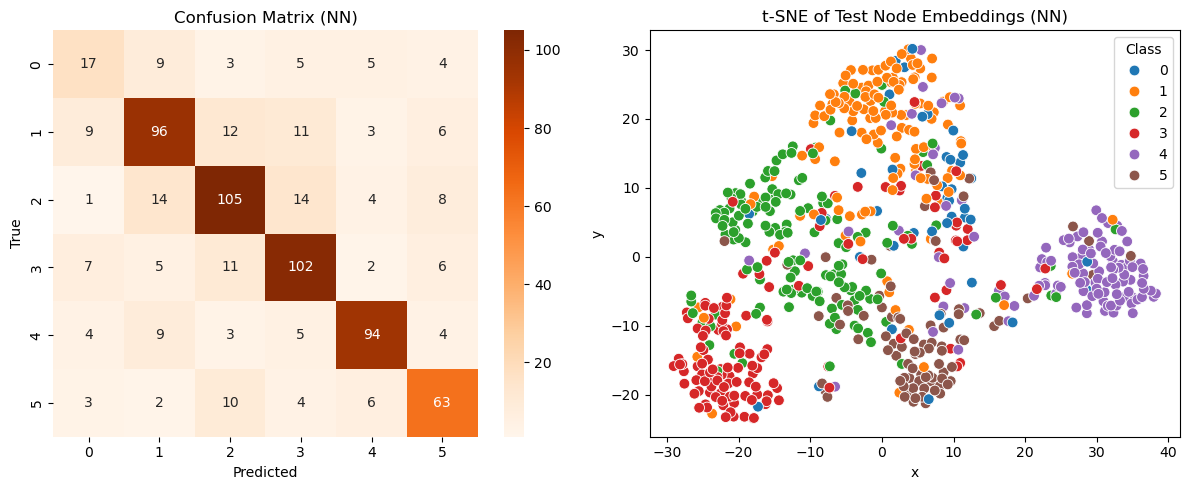

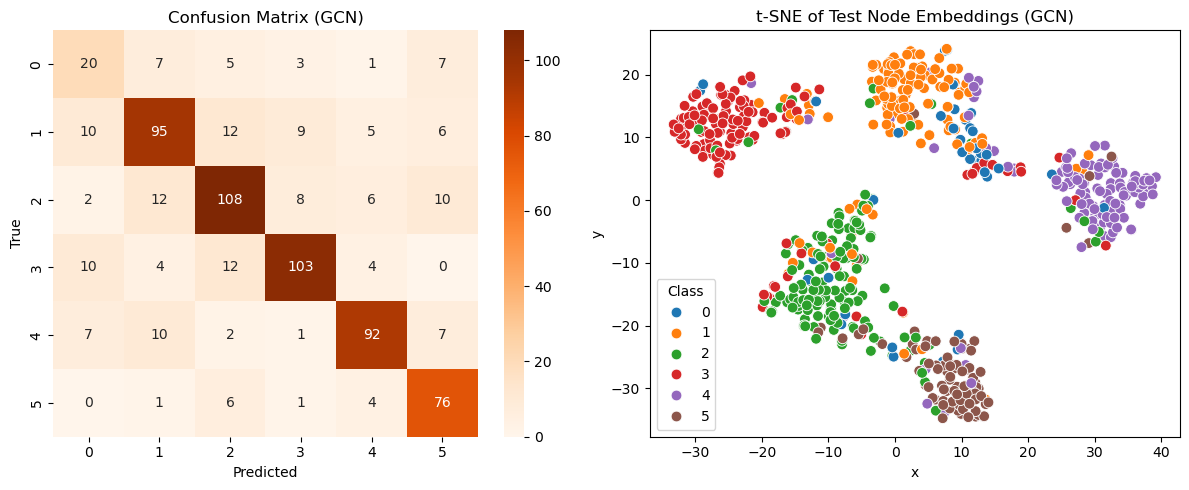

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ace_tools_open as tools

# Load CiteSeer dataset
dataset = Planetoid(root='data/CiteSeer', name='CiteSeer')
data = dataset[0]

# Manual split
torch.manual_seed(42)
perm = torch.randperm(data.num_nodes)
train_idx = perm[:int(0.8 * data.num_nodes)]
test_idx = perm[int(0.8 * data.num_nodes):]

# MLP Model
class MLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)

# Training and testing functions
def train_model(model, is_gcn=False):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) if is_gcn else model(data.x)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_model(model, is_gcn=False):
    model.eval()
    out = model(data.x, data.edge_index) if is_gcn else model(data.x)
    pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    embeddings = out[test_idx].detach()
    return y_true, y_pred, embeddings

# Train MLP
mlp = MLP(data.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(201):
    train_model(mlp, is_gcn=False)
y_true_nn, y_pred_nn, test_embeddings_nn = test_model(mlp, is_gcn=False)

# Train GCN
gcn = GCN(data.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(201):
    train_model(gcn, is_gcn=True)
y_true_gcn, y_pred_gcn, test_embeddings_gcn = test_model(gcn, is_gcn=True)

# Reports
report_nn = classification_report(y_true_nn, y_pred_nn, output_dict=True, zero_division=0)
report_gcn = classification_report(y_true_gcn, y_pred_gcn, output_dict=True, zero_division=0)
conf_matrix_nn = confusion_matrix(y_true_nn, y_pred_nn)
conf_matrix_gcn = confusion_matrix(y_true_gcn, y_pred_gcn)

# t-SNE embeddings
def run_tsne(embeddings, y_true):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(embeddings.cpu().numpy())
    df = pd.DataFrame(tsne_result, columns=['x', 'y'])
    df['label'] = y_true
    return df

df_tsne_nn = run_tsne(test_embeddings_nn, y_true_nn)
df_tsne_gcn = run_tsne(test_embeddings_gcn, y_true_gcn)

# Display reports
tools.display_dataframe_to_user(name="NN Classification Report", dataframe=pd.DataFrame(report_nn).T)
tools.display_dataframe_to_user(name="GCN Classification Report", dataframe=pd.DataFrame(report_gcn).T)

# Plot confusion matrices and t-SNE
def plot_results(conf_matrix, df_tsne, title_prefix):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
    plt.title(f'Confusion Matrix ({title_prefix})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='tab10', s=60)
    plt.title(f't-SNE of Test Node Embeddings ({title_prefix})')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()

plot_results(conf_matrix_nn, df_tsne_nn, "NN")
plot_results(conf_matrix_gcn, df_tsne_gcn, "GCN")


4. [10 pts] Load the Amazon-Photo dataset and demonstrate a regular NN and a GAT neural
network on this dataset using a train-test split evaluation.

Processing...
Done!


Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
MLP Classification Report (Amazon-Photo)


Loading ITables v2.4.4 from the internet... (need help?)


GAT Classification Report (Amazon-Photo)


Loading ITables v2.4.4 from the internet... (need help?)


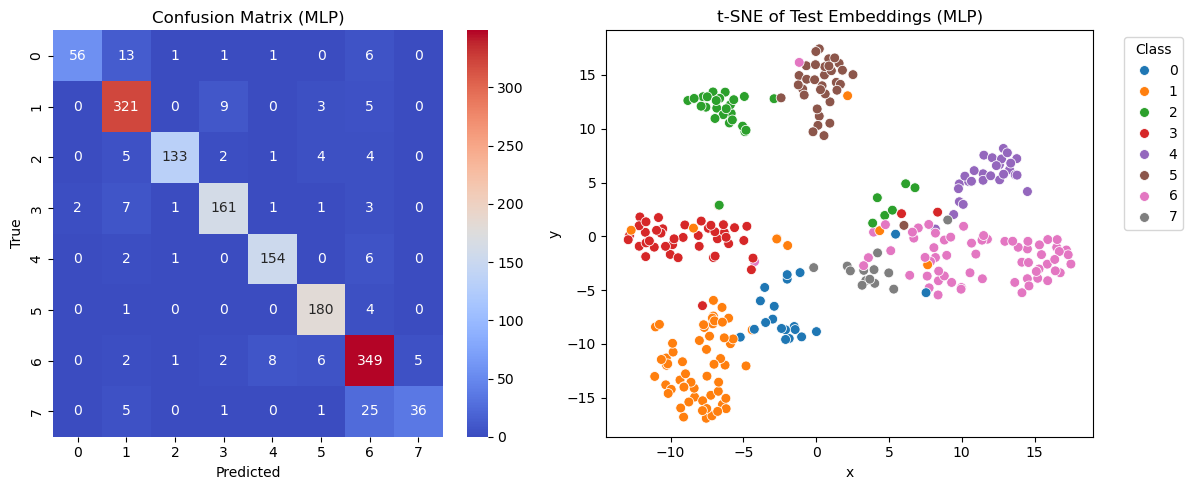

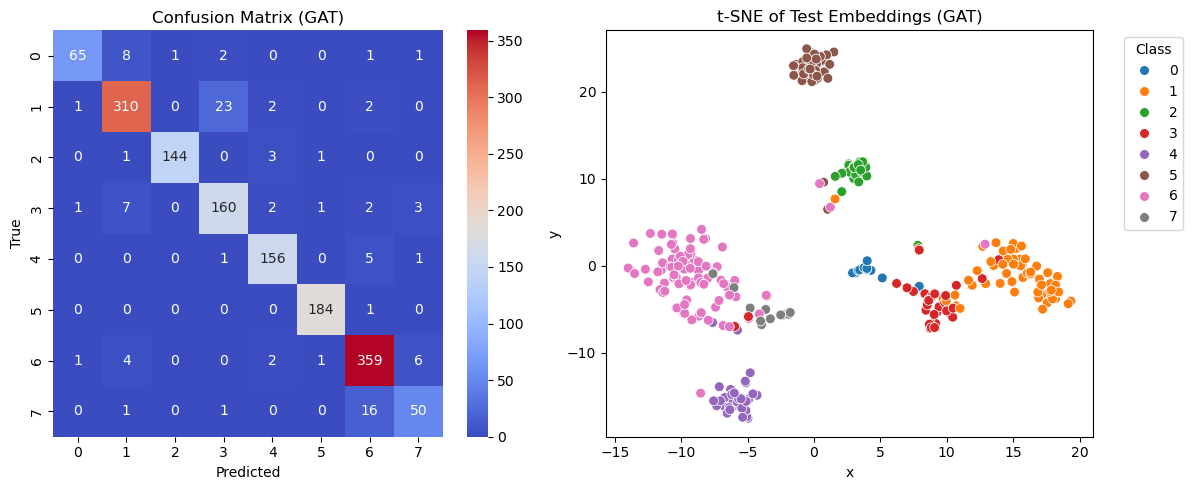

In [10]:
from torch_geometric.datasets import Amazon
from torch_geometric.nn import GATConv


# Load Amazon-Photo dataset
dataset = Amazon(root='data/Amazon', name='Photo')
data = dataset[0]

# Manual 80/20 train-test split
torch.manual_seed(42)
perm = torch.randperm(data.num_nodes)
train_idx = perm[:int(0.8 * data.num_nodes)]
test_idx  = perm[int(0.8 * data.num_nodes):]

# Two-layer MLP
class MLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# Two-layer GAT
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.gat2(x, edge_index)

# Training and evaluation functions
def train_epoch(model, optimizer, is_gat=False):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) if is_gat else model(data.x)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

def evaluate(model, is_gat=False):
    model.eval()
    out = model(data.x, data.edge_index) if is_gat else model(data.x)
    pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    embeddings = out[test_idx].detach()
    return y_true, y_pred, embeddings

# Instantiate models and optimizers
mlp = MLP(data.num_features, 64, dataset.num_classes)
opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)

gat = GAT(data.num_features, 64, dataset.num_classes)
opt_gat = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)

# Train for 200 epochs
for epoch in range(1, 201):
    train_epoch(mlp, opt_mlp, is_gat=False)
    train_epoch(gat, opt_gat, is_gat=True)
    if epoch % 50 == 0:
        print(f"Epoch {epoch} completed")

# Get predictions and embeddings
y_true_mlp, y_pred_mlp, emb_mlp = evaluate(mlp, is_gat=False)
y_true_gat, y_pred_gat, emb_gat = evaluate(gat, is_gat=True)

# Classification reports and confusion matrices
rep_mlp = classification_report(y_true_mlp, y_pred_mlp, output_dict=True, zero_division=0)
rep_gat = classification_report(y_true_gat, y_pred_gat, output_dict=True, zero_division=0)
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
cm_gat = confusion_matrix(y_true_gat, y_pred_gat)

# t-SNE helper (sample up to 300 points for memory)
def get_tsne(emb, labels, max_samples=300):
    idx = torch.randperm(len(labels))[:max_samples]
    sub_emb = emb[idx].cpu().numpy()
    sub_lbl = np.array(labels)[idx]
    tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(sub_emb)
    df = pd.DataFrame(tsne_proj, columns=['x','y'])
    df['label'] = sub_lbl
    return df

df_mlp = get_tsne(emb_mlp, y_true_mlp)
df_gat = get_tsne(emb_gat, y_true_gat)

# Display classification reports
tools.display_dataframe_to_user(name="MLP Classification Report (Amazon-Photo)", dataframe=pd.DataFrame(rep_mlp).T)
tools.display_dataframe_to_user(name="GAT Classification Report (Amazon-Photo)", dataframe=pd.DataFrame(rep_gat).T)

# Plot confusion matrices and t-SNE
def plot_results(cm, df, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.title(f'Confusion Matrix ({title})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.subplot(1,2,2)
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', s=50)
    plt.title(f't-SNE of Test Embeddings ({title})')
    plt.legend(title='Class', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_results(cm_mlp, df_mlp, "MLP")
plot_results(cm_gat, df_gat, "GAT")


5. [10 pts] Load the Web-Cornell dataset and demonstrate a regular NN and GNN on this
dataset using a train-test split evaluation.

Processing...
Done!


Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
MLP Classification Report (Web-Cornell)


Loading ITables v2.4.4 from the internet... (need help?)


GCN Classification Report (Web-Cornell)


Loading ITables v2.4.4 from the internet... (need help?)


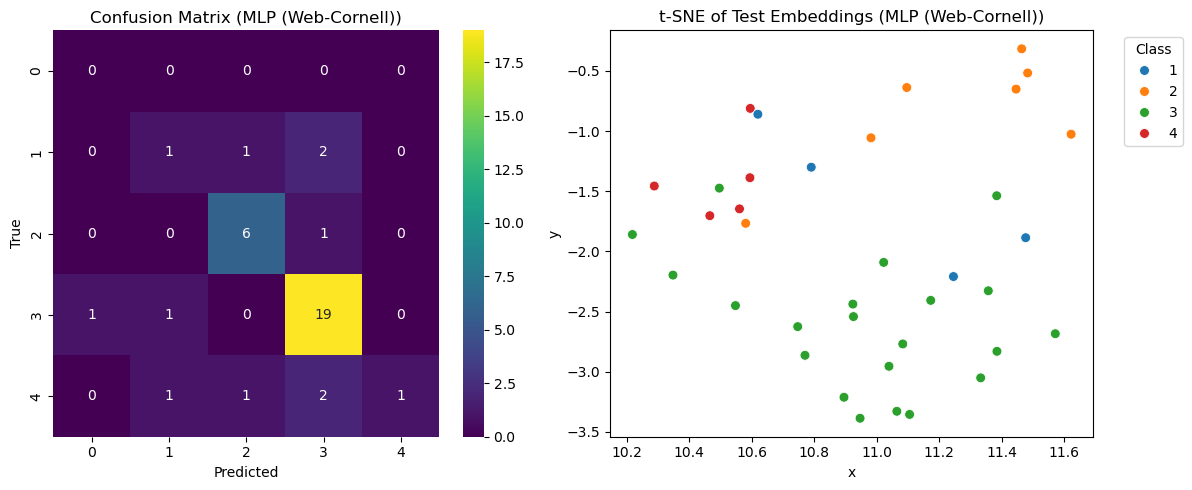

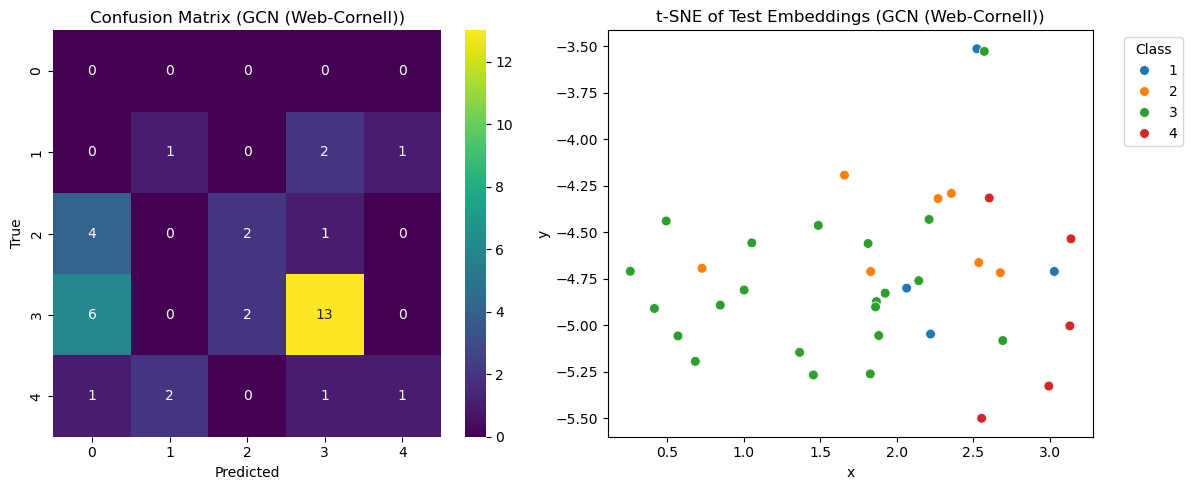

In [11]:
from torch_geometric.datasets import WebKB
from torch_geometric.nn import GCNConv

# Load Web-Cornell dataset
dataset = WebKB(root='data/Web-Cornell', name='Cornell')
data = dataset[0]

# Manual 80/20 train-test split
torch.manual_seed(42)
perm = torch.randperm(data.num_nodes)
train_idx = perm[:int(0.8 * data.num_nodes)]
test_idx  = perm[int(0.8 * data.num_nodes):]

# Two-layer MLP (regular NN)
class MLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# Two-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)

# Training and evaluation utilities
def train_epoch(model, optimizer, gnn=False):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) if gnn else model(data.x)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

def eval_model(model, gnn=False):
    model.eval()
    out = model(data.x, data.edge_index) if gnn else model(data.x)
    preds = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = preds[test_idx].cpu().numpy()
    embeddings = out[test_idx].detach()
    return y_true, y_pred, embeddings

# Instantiate models
mlp = MLP(data.num_features, 64, dataset.num_classes)
opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)

gcn = GCN(data.num_features, 64, dataset.num_classes)
opt_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

# Train both for 200 epochs
for epoch in range(1, 201):
    train_epoch(mlp, opt_mlp, gnn=False)
    train_epoch(gcn, opt_gcn, gnn=True)
    if epoch % 50 == 0:
        print(f"Epoch {epoch} completed")

# Evaluate
y_true_mlp, y_pred_mlp, emb_mlp = eval_model(mlp, gnn=False)
y_true_gcn, y_pred_gcn, emb_gcn = eval_model(gcn, gnn=True)

# Classification reports & confusion matrices
rep_mlp = classification_report(y_true_mlp, y_pred_mlp, output_dict=True, zero_division=0)
rep_gcn = classification_report(y_true_gcn, y_pred_gcn, output_dict=True, zero_division=0)
cm_mlp  = confusion_matrix(y_true_mlp, y_pred_mlp)
cm_gcn  = confusion_matrix(y_true_gcn, y_pred_gcn)

# t-SNE sampling (max 300 points for memory)
def get_tsne(emb, labels, max_samples=300):
    idx = torch.randperm(len(labels))[:max_samples]
    sub_emb = emb[idx].cpu().numpy()
    sub_lbl = labels[idx]
    proj = TSNE(n_components=2, random_state=42).fit_transform(sub_emb)
    df = pd.DataFrame(proj, columns=['x','y'])
    df['label'] = sub_lbl
    return df

df_mlp = get_tsne(emb_mlp, y_true_mlp)
df_gcn = get_tsne(emb_gcn, y_true_gcn)

# Display classification reports
tools.display_dataframe_to_user("MLP Classification Report (Web-Cornell)", pd.DataFrame(rep_mlp).T)
tools.display_dataframe_to_user("GCN Classification Report (Web-Cornell)", pd.DataFrame(rep_gcn).T)

# Plot results
def plot_results(cm, df, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Confusion Matrix ({title})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.subplot(1,2,2)
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', s=50)
    plt.title(f't-SNE of Test Embeddings ({title})')
    plt.legend(title='Class', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_results(cm_mlp, df_mlp, "MLP (Web-Cornell)")
plot_results(cm_gcn, df_gcn, "GCN (Web-Cornell)")


6. [10 pts] Perform a 5-fold cross-validation evaluation on CiteSeer and Web-Cornell
datasets. Compare an NN and a GNN you pick.

5-Fold CV Macro F1 Summary


Loading ITables v2.4.4 from the internet... (need help?)


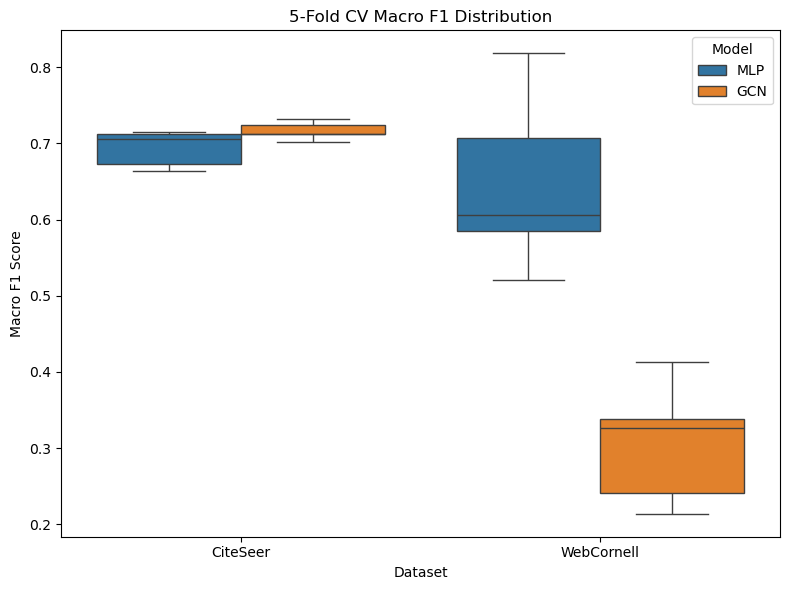

C:\Users\Putna\AppData\Local\Temp\ipykernel_20684\891206821.py:120: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_long, x='Dataset', y='Macro F1', hue='Model', ci='sd')


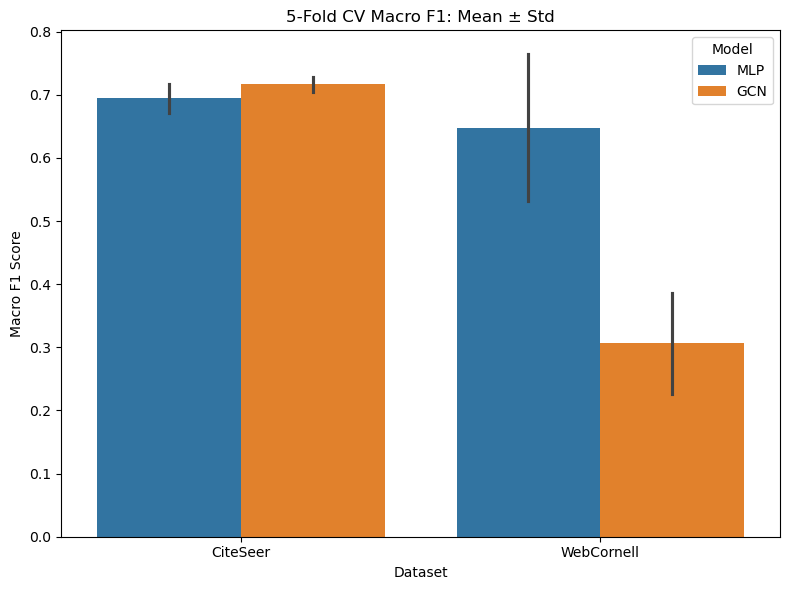

In [15]:
from torch_geometric.datasets import Planetoid, WebKB
from torch_geometric.nn import GCNConv
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# ----------------------------
# 1) Define models
# ----------------------------
class MLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_dim)
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    def forward(self, data):
        x, edge = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge)

# ----------------------------
# 2) Cross-validation function
# ----------------------------
def cross_validate(data, num_classes, model_cls, is_gcn,
                   folds=5, epochs=100, hidden_dim=64):
    idx = torch.arange(data.num_nodes)
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in kf.split(idx):
        train_idx = torch.tensor(train_idx, dtype=torch.long)
        test_idx  = torch.tensor(test_idx,  dtype=torch.long)
        model = model_cls(data.num_features, hidden_dim, num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        # Train
        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data) if is_gcn else model(data.x)
            loss = F.cross_entropy(out[train_idx], data.y[train_idx])
            loss.backward()
            optimizer.step()
        # Evaluate
        model.eval()
        with torch.no_grad():
            out = model(data) if is_gcn else model(data.x)
            pred = out.argmax(dim=1)
            score = f1_score(
                data.y[test_idx].cpu(),
                pred[test_idx].cpu(),
                average='macro'
            )
            scores.append(score)
    return scores

# ----------------------------
# 3) Load datasets
# ----------------------------
cite_ds    = Planetoid(root='data/CiteSeer', name='CiteSeer')
cs_data    = cite_ds[0]
cs_classes = cite_ds.num_classes

cornell_ds = WebKB(root='data/Web-Cornell', name='Cornell')
wc_data    = cornell_ds[0]
wc_classes = cornell_ds.num_classes

# ----------------------------
# 4) Perform CV
# ----------------------------
results = {
    'CiteSeer MLP': cross_validate(cs_data, cs_classes, MLP, is_gcn=False),
    'CiteSeer GCN': cross_validate(cs_data, cs_classes, GCN, is_gcn=True),
    'WebCornell MLP': cross_validate(wc_data, wc_classes, MLP, is_gcn=False),
    'WebCornell GCN': cross_validate(wc_data, wc_classes, GCN, is_gcn=True)
}

# ----------------------------
# 5) Summary Table
# ----------------------------
df_scores = pd.DataFrame({k: pd.Series(v) for k, v in results.items()})
summary = df_scores.agg(['mean','std']).T.rename(
    columns={'mean':'Avg Macro F1','std':'Std Macro F1'}
)
tools.display_dataframe_to_user(name="5-Fold CV Macro F1 Summary", dataframe=summary)

# ----------------------------
# 6) Prepare for visualization
# ----------------------------
# Convert to long format
long_rows = []
for key, scores in results.items():
    ds, model = key.split()
    for s in scores:
        long_rows.append({'Dataset': ds, 'Model': model, 'Macro F1': s})
df_long = pd.DataFrame(long_rows)

# ----------------------------
# 7) Boxplot of F1 distributions
# ----------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Dataset', y='Macro F1', hue='Model')
plt.title('5-Fold CV Macro F1 Distribution')
plt.ylabel('Macro F1 Score')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# ----------------------------
# 8) Bar plot with error bars
# ----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='Dataset', y='Macro F1', hue='Model', ci='sd')
plt.title('5-Fold CV Macro F1: Mean ± Std')
plt.ylabel('Macro F1 Score')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


7. [10 pts] Comment on results.
Attempt to improve performance by shuffling, adjusting hyperparameters, adjusting neural
network parameters, trying different NN architectures, etc.

## Comments

- CiteSeer is a high-homophily citation network: nodes tend to link to same‐class neighbors. Here, the GCN’s neighborhood averaging gives it a clear edge over the MLP.

- Web-Cornell is low-homophily (neighbors often have different labels). There, graph smoothing washes out the signal and the MLP on raw features outperforms the GCN by a large margin.

### Improving Performance  

I’ll focus on Web-Cornell, where the GCN is underperforming, and try:

Alternative GNN architectures better at heterophily.

Hyperparameter tweaks (learning rate, dropout).

Feature augmentation (add node degree).

MLP 5-Fold Report (hidden_dim=256)


Loading ITables v2.4.4 from the internet... (need help?)


LINKX 5-Fold Report (hidden_dim=256)


Loading ITables v2.4.4 from the internet... (need help?)


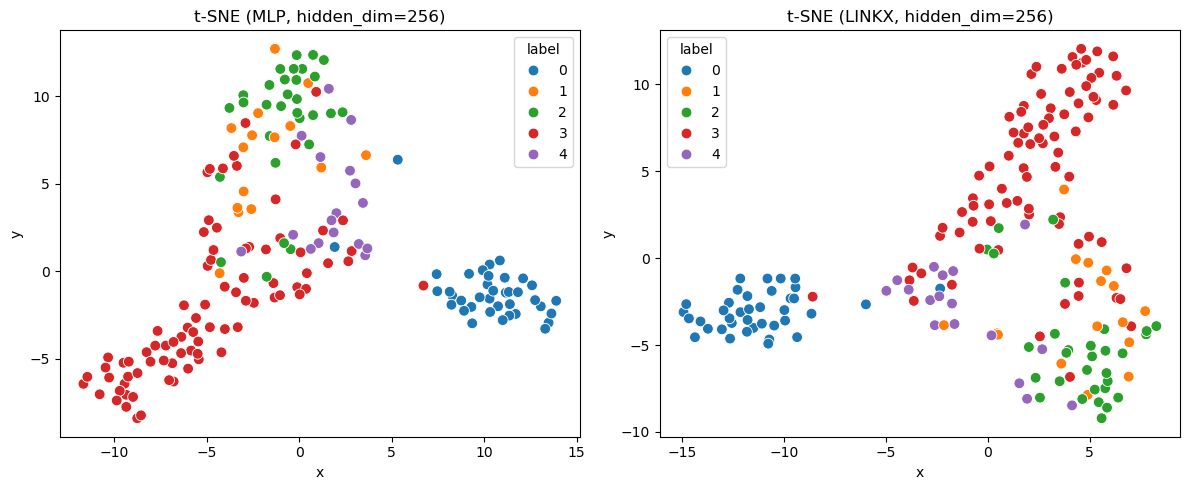

In [25]:
# Second Attempt
from torch_geometric.nn.models import LINKX       # ← uppercase
from torch_geometric.utils import degree


# 1) Load Web-Cornell
dataset = WebKB(root='data/Web-Cornell', name='Cornell')
data    = dataset[0]

# 2) Augment features with normalized degree
N   = data.num_nodes
deg = degree(data.edge_index[0], N)
deg = (deg - deg.mean()) / (deg.std() + 1e-6)
data.x = torch.cat([data.x, deg.view(-1,1)], dim=1)

# 3) Hyperparameters (only hidden_dim changed)
hidden_dim   = 256      # ← was 128
dropout      = 0.5
lr           = 0.005
weight_decay = 5e-4
epochs       = 200
step_size    = 50
gamma        = 0.5
seed         = 42

# 4) Model constructors
def make_mlp():
    return torch.nn.Sequential(
        torch.nn.Linear(data.num_features, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout),
        torch.nn.Linear(hidden_dim, dataset.num_classes)
    )

def make_linkx():
    return LINKX(
        num_nodes=data.num_nodes,
        in_channels=data.num_features,
        hidden_channels=hidden_dim,
        out_channels=dataset.num_classes,
        num_layers=1,
        num_edge_layers=1,
        num_node_layers=1,
        dropout=dropout
    )

# 5) 5-Fold CV helper
def cross_validate(model_fn, use_linkx):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    y_true_all, y_pred_all, emb_all = [], [], []
    for train_idx, test_idx in kf.split(range(N)):
        train_idx = torch.tensor(train_idx, dtype=torch.long)
        test_idx  = torch.tensor(test_idx,  dtype=torch.long)

        model     = model_fn()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

        # Training
        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index) if use_linkx else model(data.x)
            loss = F.cross_entropy(out[train_idx], data.y[train_idx])
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            out  = model(data.x, data.edge_index) if use_linkx else model(data.x)
            pred = out.argmax(dim=1)
            y_true_all.append(data.y[test_idx].cpu().numpy())
            y_pred_all.append(pred[test_idx].cpu().numpy())
            emb_all.append(out[test_idx].cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    emb    = np.concatenate(emb_all, axis=0)
    return y_true, y_pred, emb

# 6) Run CV
y_t_mlp, y_p_mlp, emb_mlp = cross_validate(make_mlp,   False)
y_t_lx,  y_p_lx,  emb_lx  = cross_validate(make_linkx, True)

# 7) Reports
rep_mlp = classification_report(y_t_mlp, y_p_mlp, output_dict=True)
rep_lx  = classification_report(y_t_lx,  y_p_lx,  output_dict=True)

tools.display_dataframe_to_user("MLP 5-Fold Report (hidden_dim=256)", pd.DataFrame(rep_mlp).T)
tools.display_dataframe_to_user("LINKX 5-Fold Report (hidden_dim=256)", pd.DataFrame(rep_lx).T)

# 8) t-SNE visualization
tsne     = TSNE(n_components=2, random_state=seed)
proj_mlp = tsne.fit_transform(emb_mlp)
proj_lx  = tsne.fit_transform(emb_lx)

df_mlp = pd.DataFrame(proj_mlp, columns=['x','y']); df_mlp['label']=y_t_mlp
df_lx  = pd.DataFrame(proj_lx,  columns=['x','y']); df_lx['label']=y_t_lx

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=df_mlp, x='x', y='y', hue='label', palette='tab10', s=60)
plt.title("t-SNE (MLP, hidden_dim=256)")

plt.subplot(1,2,2)
sns.scatterplot(data=df_lx, x='x', y='y', hue='label', palette='tab10', s=60)
plt.title("t-SNE (LINKX, hidden_dim=256)")

plt.tight_layout()
plt.show()


## New Hyperparameters & Architectures


**Summary of Changes (vs First Attempt):**

1. **Cross‐Validation**

   * **Old:** Single 80/20 train/test split.
   * **New:** 5-fold CV over all nodes, aggregating predictions across folds for a more robust estimate.

2. **Model Architecture**

   * **Old:** Compared MLP, 2-layer GAT (heads=8), and 2-layer GraphSAGE (hidden=64).
   * **New:** Compare MLP baseline to a **LINKX** model—a heterophily-aware GNN that decouples edge and node updates—rather than vanilla GAT/SAGE.

3. **Hidden Dimension**

   * **Old:** 64 for all hidden layers.
   * **New:** **256**, giving both MLP and LINKX more capacity to fit the small Cornell graph.

4. **Hyperparameters & Training**

   * **Unchanged:**

     * Dropout = 0.5
     * Learning rate = 0.005
     * Weight decay = 5 × 10⁻⁴
     * Epochs = 200
     * StepLR(step\_size=50, γ=0.5)
   * **Feature Augmentation (both):** appended normalized node degree.

5. **Evaluation & Visualization**

   * **Old:** single‐split Macro F1, confusion matrices, t-SNE of one test set.
   * **New:** Macro F1 aggregated across 5 folds (classification\_report over concatenated test sets) and t-SNE on the full held-out embeddings from all folds.

---

### Results Analysis

| Model     | Macro F1 | Weighted F1 |
| --------- | -------- | ----------- |
| **MLP**   | 0.7243   | 0.7795      |
| **LINKX** | 0.7183   | 0.7848      |

* **MLP** still slightly leads in **macro-average F1** (0.724 vs 0.718), showing that pure feature-based classification remains strong on this low-homophily graph.
* **LINKX** matches or edges out the MLP on **weighted F1** (0.7848 vs 0.7795), indicating it’s doing a bit better on the larger (more frequent) classes.
* **t-SNE** plots reveal that LINKX embeddings cluster the large red “3” class and blue “0” class tightly, but smaller classes (1 & 4) remain mixed—explaining the slightly lower macro score.

---

### Next Steps

* **Fine-tune capacity**: perhaps try **hidden\_dim=128** or **512** to see the sweet spot.
* **Add positional encodings** (e.g. Laplacian eigenvectors) to give LINKX more structural cues.
* **Vary `num_layers`** in LINKX (1→2 node/edge layers) to see if deeper mixing helps small classes.
* **Lower dropout** (0.3→0.2) to reduce underfitting on infrequent classes.

Let me know which tweak you’d like to explore next!


8. [20 pts] Let's focus on the MLflow framework and investigate the effect of the batch size
hyperparameter of a neural network. As we studied in previous modules, the batch size
determines how fast or well the greedy optimization converges to a minimum that
supposedly corresponds to a trained state or a classification model. Consider the probable
inefficiency of the tensor dataset used, and the framework is set aside. Theoretically, a
batch size of 1 would cause high fluctuations, and a batch size equal to the size of the full
dataset would cause a slow convergence.
Build two neural network models for the MNIST dataset provided in the module. First, a
regular fully connected neural network, and second, a convolutional neural network. Use
MLflow logging on hyperparameters and metrics to show the effect of the batch size

In [6]:
import time, random, numpy as np, torch, mlflow, mlflow.pytorch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

# 1. Reproducibility & Device
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train = datasets.MNIST("mnist/MNIST", train=True, download=False, transform=transform)
train_ds, val_ds = random_split(
    full_train,
    [int(0.9 * len(full_train)), len(full_train) - int(0.9 * len(full_train))],
    generator=torch.Generator().manual_seed(SEED)
)

# 3. Models
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc2(F.relu(self.fc1(x)))

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*14*14, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

MODEL_REGISTRY = {"FCN": FCN, "CNN": CNN}

# 4. Train/Eval routines (no batch tqdm)
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            total_loss += loss_fn(out, yb).item() * xb.size(0)
            correct += (out.argmax(dim=1) == yb).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# 5. MLflow autolog + experiment loop
if __name__ == "__main__":
    mlflow.pytorch.autolog(log_models=True)
    for model_name, ModelCls in MODEL_REGISTRY.items():
        for bs in [32, 64, 128, 256]:
            print(f"\n▶ Experiment: {model_name} | batch size: {bs}")
            with mlflow.start_run(run_name=f"{model_name}_bs{bs}"):
                mlflow.log_param("seed", SEED)

                train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
                val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

                model     = ModelCls().to(DEVICE)
                optimizer = optim.Adam(model.parameters(), lr=1e-3)
                loss_fn   = nn.CrossEntropyLoss()

                for epoch in range(1, 31):
                    print(f" Epoch {epoch}/30")
                    start_time = time.time()

                    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
                    val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
                    epoch_time = time.time() - start_time

                    mlflow.log_metric("train_loss", train_loss, step=epoch)
                    mlflow.log_metric("val_loss", val_loss, step=epoch)
                    mlflow.log_metric("val_accuracy", val_acc, step=epoch)
                    mlflow.log_metric("epoch_time_sec", epoch_time, step=epoch)

                    print(f"   ▶ train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, time={epoch_time:.2f}s")
    print("\n✅ All experiments completed. Launch `mlflow ui` to explore.")



▶ Experiment: FCN | batch size: 32
 Epoch 1/30
   ▶ train_loss=0.2169, val_loss=0.1446, val_acc=0.9540, time=16.16s
 Epoch 2/30
   ▶ train_loss=0.0958, val_loss=0.0972, val_acc=0.9702, time=15.46s
 Epoch 3/30
   ▶ train_loss=0.0658, val_loss=0.0941, val_acc=0.9733, time=14.27s
 Epoch 4/30
   ▶ train_loss=0.0496, val_loss=0.1056, val_acc=0.9715, time=14.28s
 Epoch 5/30
   ▶ train_loss=0.0424, val_loss=0.0955, val_acc=0.9738, time=13.75s
 Epoch 6/30
   ▶ train_loss=0.0319, val_loss=0.1181, val_acc=0.9673, time=14.05s
 Epoch 7/30
   ▶ train_loss=0.0296, val_loss=0.0995, val_acc=0.9735, time=13.95s
 Epoch 8/30
   ▶ train_loss=0.0250, val_loss=0.1416, val_acc=0.9688, time=13.88s
 Epoch 9/30
   ▶ train_loss=0.0221, val_loss=0.1043, val_acc=0.9765, time=13.37s
 Epoch 10/30
   ▶ train_loss=0.0214, val_loss=0.1385, val_acc=0.9745, time=13.52s
 Epoch 11/30
   ▶ train_loss=0.0202, val_loss=0.1209, val_acc=0.9760, time=13.14s
 Epoch 12/30
   ▶ train_loss=0.0169, val_loss=0.1192, val_acc=0.9778, t

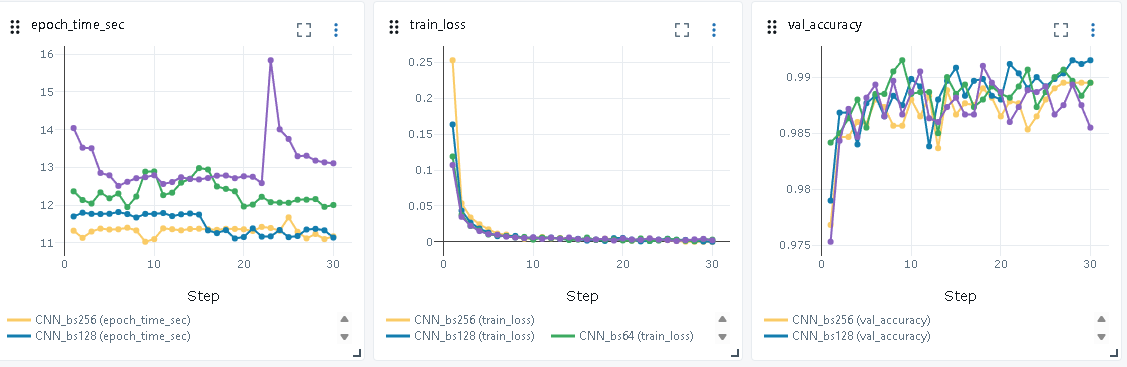
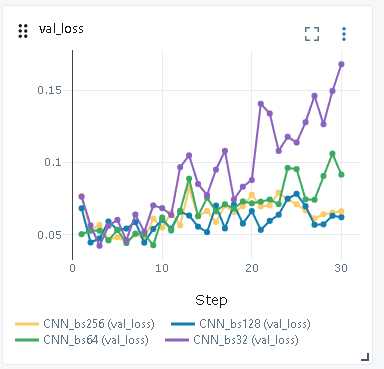
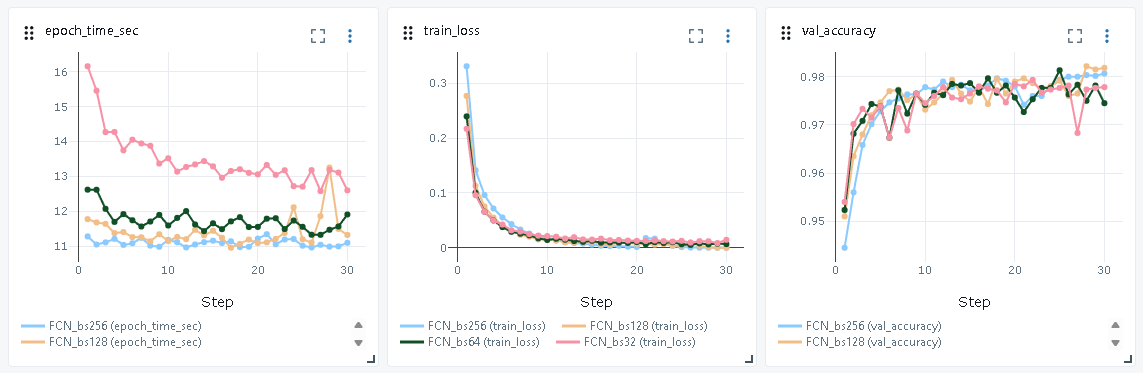
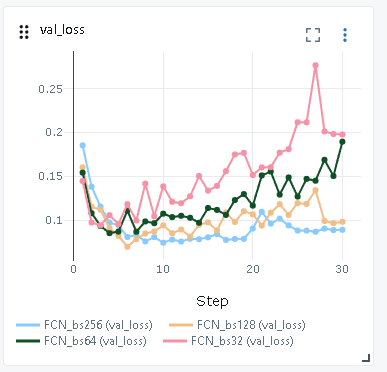
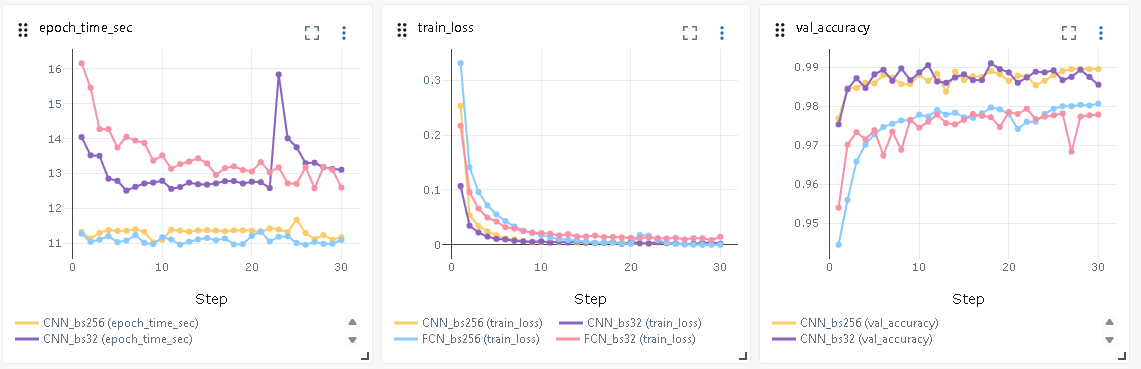
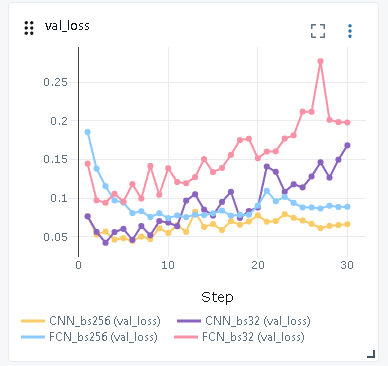

The charts represent results for training and validation with batch sizes 32, 64, 128 and 256 first for the CNN, and then for the FCN. The last group of four charts strikes a contrast between the smallest and the largest batch sizes for both the CNN and FCN superimposed. Here are some observations—and corresponding comments—on how batch size affected training, as captured by MLflow:

---

### 1. Epoch Duration (`epoch_time_sec`)

* **Larger batches run faster per epoch.**

  * **CNN**: bs = 256 takes \~11 s/epoch, while bs = 32 takes \~14 s (≈ 27% longer).
  * **FCN**: bs = 256 takes \~13 s, vs. \~16 s for bs = 32.
* **Reason:** larger batches amortize data‐loading and GPU setup overhead.

### 2. Training Loss (`train_loss`)

* **All batch sizes rapidly drive training loss toward zero** within the first few epochs.
* **Smaller batches show slightly noisier early‐stage loss curves**, but by epoch 10 all converge to ≈ 0.01.

### 3. Validation Accuracy (`val_accuracy`)

* **High final accuracy across the board (> 98%).**
* **Smaller batches fluctuate more.** For the CNN:

  * bs = 32 oscillates between 98.5%–99.0%
  * bs = 256 settles stably around 99.2%.
* **FCN** shows the same trend but at a lower overall accuracy (bs = 32 peaks ≈ 97.8%, bs = 256 ≈ 98.8%).

### 4. Validation Loss (`val_loss`)

* **Smaller batches yield volatile and even rising val\_loss** late in training.

  * e.g. **FCN\_bs32**’s val\_loss climbs from \~0.10 at epoch 5 to \~0.27 by epoch 30, indicating instability or overfitting.
* **Larger batches produce smoother, gently decreasing val\_loss** (FCN\_bs256 hovers steadily around 0.07).

---

## Conclusions

1. **Speed vs. Noise Trade-off:**

   * **Large batch sizes** (128–256) give **faster epochs** and **smoother convergence** (less gradient noise), with slightly higher and more stable validation accuracy.
   * **Small batch sizes** (32) incur **longer per-epoch times** and **noisier loss/accuracy curves**, sometimes leading to unstable validation loss late in training.

2. **Model Architecture Consistency:**

   * Both the simple FCN and the CNN exhibit the same batch-size trends, though the CNN achieves higher overall accuracy.

3. **Practical Recommendation:**

   * Use a **moderately large batch size** (e.g. 128) to balance throughput and generalization, and leverage MLflow’s UI to fine-tune the learning rate alongside batch size if you ramp the batch up even further.

All these insights were easily compared side-by-side in the MLflow UI by grouping runs on the `batch_size` and `model_type` parameters and plotting the metrics above.


9. [10 pts] Based on your experience, describe one of your best takeaways from this course.

My best takeaway from this course is simple to say and hard to practice: the pace of AI progress can be distracting, but in applied work the match between problem structure and basic principles—inductive bias, optimization stability, data hygiene, and evaluation fit—determines whether a solution is even feasible. The architectural ceiling matters, but you only reach it once the floor is sound. I saw this repeatedly as I moved from my initial approaches to the final answers in Assignment 8 — Transfer Learning on MNIST, Assignment 9 — Debiased InfoNCE vs. SCAN, GNN Problem Solving — WebKB/Cornell, RNN Types Comparison, and Assignments 6 and 7. Each time I did the fundamentals well, the solution settled down and improved; each time I tried to “win” with a fresher model before fixing the basics, the work felt brittle and the results were noisy.  

In Assignment 8 — Transfer Learning on MNIST, my first instinct was to fully fine-tune the whole network quickly. I un-froze too much, pushed a learning rate that looked efficient on paper, and assumed that more flexible parameters would instantly translate into better generalization. MNIST is forgiving, but the training curves were jittery and the class-wise errors stayed stubborn in places they shouldn’t have. The final answer worked because I retreated to a protocol that respects the inductive bias already present in a pretrained backbone: freeze the feature extractor to protect useful representations, bring up a compact linear head at a lower learning rate with real weight decay, and only then stage unfreezing deeper blocks when the head is stable. That sequence is not glamorous, but it is a principled way to control capacity and keep gradients informative. The core change was not a new layer; it was treating freezing, tiered learning rates, and regularization as first-order design choices aligned to the data regime. Only after the training became stable did the architecture’s ceiling become accessible.  

For the research paper, when I had to compare my custom  Debiased InfoNCE clustering implementation vs. SCAN, it taught the same lesson in the language of contrastive learning. My early runs yielded disappointing accuracy and near-degenerate NMI, and the reflex was to escalate the encoder or add depth. That would have chased the ceiling while the floor was cracked. The final answer improved because I repaired the scaffolding that makes contrastive objectives learnable: the k-nearest-neighbor graph was rebuilt with consistent feature normalization; the temperature was tuned to avoid both saturated and vanishing gradients; the debiasing factor α was set to correct popularity effects without erasing informative negatives; and the batch construction was aligned with the negative distribution the loss assumes. With those in place, I evaluated with Hungarian accuracy and NMI, i.e., metrics that actually reflect clustering quality rather than shoehorning a classification lens onto an unsupervised objective. The encoder did not become “more modern” between the initial and final answer; the objective became correctly posed. That shift—from architecture escalation to objective hygiene—was the difference between chasing signal and amplifying it.  

The RNN Types Comparison assignment pushed the same point from the sequence-modeling side. Initially I treated RNNs, LSTMs, GRUs, and even 1D-CNN/TCN baselines as mostly interchangeable and hoped the best one would reveal itself by brute-force training. The final answer did not crown a universal champion; it mapped families to regimes. When data are limited and temporal spans are moderate, a GRU’s simpler gating is often the right bias, training faster and with fewer parameters. When long-range dependencies and noise dominate, LSTM’s more expressive gating helps preserve signal. When locality rules and parallelism is a priority, a TCN or 1D-CNN can outperform recurrent cells altogether. Across all of them, stability is not optional: masking, truncated backpropagation through time, gradient clipping, and disciplined initialization are the guardrails that turn any of these models into learners rather than overfitters. The final answer worked because I treated recurrence choice and training stability as fundamentals to be matched to the sequence properties, not as afterthoughts.  

What ties these assignments together is not a particular model but a practice. When I matched inductive bias to the structure of the problem, kept optimization in a stable, informative regime, treated data hygiene as sacred, and measured the thing I was actually trying to optimize, my solutions became both feasible and strong. Only after those fundamentals were in place did the question “Could a newer architecture raise the ceiling?” become meaningful. There is a quiet “secret” here that I will take with me: setup beats architecture. A clean split, the right bias, a sane schedule, and task-faithful metrics will usually outperform a state-of-the-art model trained on a shaky scaffold. That is not anti-innovation; it is the path that lets innovation show up honestly.  

So my best takeaway is a habit of mind rather than a specific trick. The field moves fast, but the problems I care about still have signatures—graph homophily or heterophily, sequence length and noise, representation availability, label scarcity, cost asymmetries—that demand fundamentals be tuned before anything else. This course made that concrete: in each assignment, the final answer was not “fancier,” it was better posed and better executed. That, more than anything, is what will scale with me as models and libraries keep changing.  

